In [1]:
import os,sys,signal
import math

import pickle
import numpy as np                                       # fast vectors and matrices
import matplotlib.pyplot as plt                          # plotting

import musicnet

from time import time

from sklearn.metrics import average_precision_score

os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'   # see issue #152
os.environ['CUDA_VISIBLE_DEVICES']='3'

import torch
from torch.nn.functional import conv1d, mse_loss
import torch.nn.functional as F
import torch.nn as nn

if torch.cuda.is_available():
    device = "cuda:0"
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [2]:
# Network Parameters
epochs = 20
train_size = 100000
test_size = 50000

lr = 0.0001
momentum = .95

pitch_shift = 0
jitter = 0.
num_workers = 10
sequence = 1

# lvl1 convolutions are shared between regions
m = 128
k = 512              # lvl1 nodes
n_fft = 4096              # lvl1 receptive field
window = 16384 # total number of audio samples?
stride = 512
batch_size = 100

regions = 1 + (window - n_fft)//stride

def worker_init(args):
    signal.signal(signal.SIGINT, signal.SIG_IGN) # ignore signals so parent can handle them
    np.random.seed(os.getpid() ^ int(time())) # approximately random seed for workers
kwargs = {'num_workers': num_workers, 'pin_memory': True, 'worker_init_fn': worker_init}

In [3]:
# function for returning scientific notation in a plot
def fmt(x, pos):
    a, b = '{:.0e}'.format(x).split('e')
    b = int(b)
    return fr'${a} \times 10^{{{b}}}$'

In [4]:
result_dict = {'loss_history_train': [],
               'avgp_history_train': [],
               'loss_history_test': [],
               'avgp_history_test': [],
               'parameters': {}}

result_dict['parameters']['train_size'] = train_size
result_dict['parameters']['test_size'] = test_size
result_dict['parameters']['lr'] = lr
result_dict['parameters']['pitch_shift'] = pitch_shift
result_dict['parameters']['jitter'] = jitter

# Preparing Dataset

In [5]:
start = time()
root = './data/'
train_set = musicnet.MusicNet(root=root, epoch_size=train_size,sequence=sequence
                              , train=True, download=True, refresh_cache=False, 
                              window=window, mmap=False, pitch_shift=pitch_shift, jitter=jitter)
test_set = musicnet.MusicNet(root=root, train=False, download=True,sequence=sequence
                             , refresh_cache=False, window=window, epoch_size=test_size, mmap=False)
print("Data loaded, time used = {:2.2f} seconds".format(time()-start))

train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,**kwargs)
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,**kwargs)

Data loaded, time used = 29.59 seconds


# Defining Models

In [6]:
Loss = torch.nn.MSELoss()
def L(yhatvar,y):
    return Loss(yhatvar,y) * 128/2

In [7]:
class Model(torch.nn.Module):
    def __init__(self, avg=.9998):
        super(Model, self).__init__()      
        # Create filter windows
        wsin, wcos = musicnet.create_filters(n_fft,k, low=50, high=6000,
                                      windowing="hann", freq_scale='log')
        self.wsin = torch.Tensor(wsin)
        self.wcos = torch.Tensor(wcos)               
        # Creating Layers
        
        k_out = 128
        k2_out = 256
        self.CNN_freq = nn.Conv2d(1,k_out,
                                kernel_size=(128,1),stride=(2,1))
        self.CNN_time = nn.Conv2d(k_out,k2_out,
                                kernel_size=(1,25),stride=(1,1))        
        self.linear = torch.nn.Linear(k2_out*193, m, bias=False)

        # Initialize weights
            # Do something
        
    def forward(self,x):
        zx = conv1d(x[:,None,:], self.wsin, stride=stride).pow(2) \
           + conv1d(x[:,None,:], self.wcos, stride=stride).pow(2) # shape = (batch, 512,25)
        zx = torch.log(zx + 1e-12)
        z2 = torch.relu(self.CNN_freq(zx.unsqueeze(1))) # Make channel as 1 (N,C,H,W) shape = [10, 128, 193, 25]
        z3 = torch.relu(self.CNN_time(z2)) # shape = [10, 256, 193, 1]
        y = self.linear(torch.relu(torch.flatten(z3,1)))
        return y

In [8]:
model = Model()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = SWA(base_opt, swa_start=0, swa_freq=1, swa_lr=0.000001)

In [9]:
try:
    with train_set, test_set:
        print("epoch\ttrain loss\ttest loss\ttrain avg\ttest avg\ttime\tutime")
        for e in range(epochs):
            yground = torch.Tensor(batch_size*len(train_loader), m) # what not do this together with loss
            yhat = torch.Tensor(batch_size*len(train_loader), m)
            avgp, loss_e = 0.,0
            t = time()
            for i, (x,y) in enumerate(train_loader):
                print(f"training {i}/{len(train_loader)} batches", end = '\r')
                optimizer.zero_grad()

                # making x and y into pytorch dealable format
                x = x.to(device, non_blocking=True)
                y = y.to(device, non_blocking=True)
                yhatvar = model(x)
                loss = L(yhatvar,y)
                loss.backward()
                loss_e += loss.item() #getting the number

                yground[i*batch_size:(i+1)*batch_size] = y.data
                yhat[i*batch_size:(i+1)*batch_size] = yhatvar.data

                optimizer.step()
            avgp = average_precision_score(yground.cpu().flatten(),yhat.cpu().flatten())  

            result_dict['loss_history_train'].append(loss_e/len(train_loader))
            result_dict['avgp_history_train'].append(avgp)   
            t1 = time()
            avgp, loss_e = 0.,0.           
#             optimizer.swap_swa_sgd() # change to average weight

            # For testing
            yground = torch.Tensor(batch_size*len(test_loader), m) # what not do this together with loss
            yhat = torch.Tensor(batch_size*len(test_loader), m)

            for i, (x_test,y_test) in enumerate(test_loader):
                print(f"testing {i}/{len(test_loader)} batches", end = '\r')
                x_test = x_test.to(device)
                y_test = y_test.to(device)
                yhatvar = model(x_test)
                loss_e += L(yhatvar, y_test).item() #getting the number

                yground[i*batch_size:(i+1)*batch_size] = y_test.data
                yhat[i*batch_size:(i+1)*batch_size] = yhatvar.data
            avgp = average_precision_score(yground.cpu().flatten(),yhat.cpu().flatten())
            result_dict['loss_history_test'].append(loss_e/len(test_loader))
            result_dict['avgp_history_test'].append(avgp)
            print('{}\t{:2f}\t{:2f}\t{:2f}\t{:2f}\t{:2.1f}\t{:2.1f}'.\
                  format(e,
                         result_dict['loss_history_train'][-1],result_dict['loss_history_test'][-1],
                         result_dict['avgp_history_train'][-1],result_dict['avgp_history_test'][-1],
                         time()-t, time()-t1))

except KeyboardInterrupt:
    print('Graceful Exit')
else:
    print("Finsihed")

epoch	train loss	test loss	train avg	test avg	time	utime
0	1.334337	0.666874	0.304153	0.641615	142.3	15.8
1	0.807517	0.613933	0.656501	0.669936	167.7	16.3
2	0.763797	0.588617	0.681749	0.681390	167.1	16.1
3	0.746471	0.589144	0.691150	0.693510	167.4	16.2
4	0.727146	0.564344	0.702049	0.700684	167.5	15.9
5	0.720195	0.568286	0.704461	0.698985	167.2	16.0
6	0.713054	0.559188	0.709818	0.705210	167.3	16.0
7	0.704705	0.556545	0.714311	0.703718	167.2	15.9
8	0.692383	0.561071	0.720918	0.708594	167.0	15.9
9	0.693837	0.558380	0.722269	0.705544	167.0	15.8
10	0.685768	0.546141	0.725579	0.714696	167.8	16.5
11	0.679332	0.556351	0.731067	0.712460	167.4	16.3
12	0.676547	0.543720	0.734982	0.713432	167.4	16.0
13	0.672068	0.541065	0.737311	0.716298	167.4	16.0
14	0.666876	0.545209	0.740286	0.721806	168.4	16.2
15	0.663383	0.539024	0.742817	0.723213	167.5	16.0
16	0.660346	0.545575	0.746485	0.727558	167.2	15.8
17	0.656616	0.536008	0.748405	0.724596	166.8	15.8
18	0.653261	0.538894	0.749718	0.721433	166.9	15.9
19	

(0.3, 0.8)

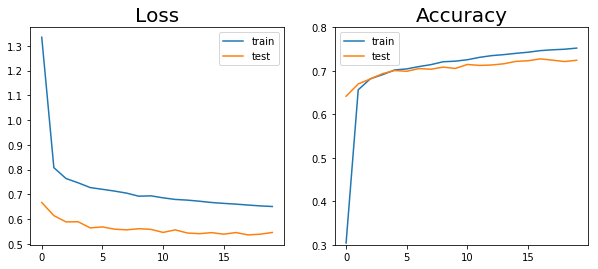

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

ax[0].plot(result_dict['loss_history_train'])
ax[0].plot(result_dict['loss_history_test'])
ax[0].legend(['train', 'test'])
ax[0].set_title('Loss', size=20)

ax[1].plot(result_dict['avgp_history_train'])
ax[1].plot(result_dict['avgp_history_test'])
ax[1].legend(['train', 'test'])
ax[1].set_title('Accuracy', size=20)
ax[1].set_ylim(0.3,0.80)

# Mir_Eval stats

In [11]:
print('AvgP\tP\tR\tAcc\tETot\tESub\tEmiss\tEfa')
Accavg = 0
Etotavg = 0
model.eval()
for songid in test_set.rec_ids:  
    Y_pred, Y_true = musicnet.get_piano_roll(songid, test_set, model, device,
                                             window=window, m=m, stride=-1)
    _,_,_,Acc,Etot = musicnet.get_mir_accuracy(Y_pred, Y_true, m=m)
    Accavg += Acc
    Etotavg += Etot

AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
77.73	73.47	76.53	0.60	0.40	0.12	0.12	0.16
80.39	71.85	79.11	0.60	0.42	0.10	0.11	0.21
47.22	56.63	43.19	0.32	0.76	0.14	0.43	0.19
70.83	60.15	79.66	0.52	0.66	0.07	0.13	0.45
73.84	59.10	87.68	0.55	0.62	0.11	0.01	0.50
74.30	70.19	70.27	0.54	0.44	0.15	0.15	0.15
70.34	70.28	67.16	0.52	0.47	0.14	0.18	0.14
73.12	68.43	71.43	0.54	0.49	0.12	0.16	0.21
78.36	73.18	73.55	0.58	0.44	0.09	0.17	0.18
72.89	68.05	76.48	0.56	0.48	0.12	0.12	0.24


In [ ]:
print('Average Accuracy: \t{:2.2f}\nAverage Error: \t\t{:2.2f}'
      .format(Accavg/len(test_set.rec_ids)*100, Etotavg/len(test_set.rec_ids)*100))

# Saving weights and results

In [ ]:
torch.save(model.state_dict(), './weights/translation_invariant_baseline')
with open('./result_dict/translation_invariant_baseline', 'wb') as f:
    pickle.dump(result_dict, f)

In [ ]:
from numba import cuda
cuda.select_device(0)
cuda.close()